# Over-Refusal Evaluation Analysis

- 1: Overall Refusal Rate (RR) and Answer Rate (EN/CN/MIX)
- 2: Language Refusal Variance (ΔRR)
- 3: Refusal Rate by Category (EN/CN/MIX)
- 4: Refusal Rate by Rewrite Method (EN/CN/MIX)
- 5: Cross-Language Consistency (CLC) (Overall Statistics + Pattern Distribution)
- 6: Language Bias Index (LBI) (= RR Variance across Three Languages) and Count/Refusal Rate for Each Language
- 7: Three Languages ​​× Answer Rate and Refusal Rate for Each Category
- 8: Three Languages ​​× Answer Rate and Refusal Rate for Each Rewrite Method

-  1：总体拒答率 RR 与回答率（EN/CN/MIX）  
-  2：语言拒答差异率 ΔRR  
-  3：按类别（Category）的拒答率（EN/CN/MIX）  
-  4：按改写方式（Rewrite Method）的拒答率（EN/CN/MIX）  
-  5：跨语言一致性 CLC（总体统计 + 模式分布）  
-  6：语言偏差指数 LBI（= 三语言 RR 方差）与各语言计数/拒答率   
-  7：三种语言 × 各 Category 的回答率与拒绝率  
-  8：三种语言 × 各 Rewrite Method 的回答率与拒绝率  


## 2. Import dataset

In [1]:
# Import necessary packages
import pandas as pd
import altair as alt
import numpy as np

In [2]:
CSV_PATH = "evaluation-111.csv"  # 如果路径不同，这里改一下
use_cols = [
    "Category", "Rewrite Method", "English", "Chinese", "Mixed",
    "gemini25flash_result_en_label", "gemini25flash_result_cn_label", "gemini25flash_result_mix_label"
]
df = pd.read_csv(CSV_PATH, usecols=use_cols)

# Summarize dataset info
df.columns = [c.strip() for c in df.columns]
summary = pd.DataFrame({
    "Column Name": df.columns,
    "Data Type": [str(df[c].dtype) for c in df.columns],
    "Non-Null Count": [df[c].notna().sum() for c in df.columns],
    "Missing Count": [df[c].isna().sum() for c in df.columns],
    "Unique Values": [df[c].nunique(dropna=True) for c in df.columns],
})
print(f"Number of samples: {len(df)} | Number of columns: {len(df.columns)}")
display(summary)

Number of samples: 165 | Number of columns: 8


,Column Name,Data Type,Non-Null Count,Missing Count,Unique Values
0,Category,object,165,0,15
1,Rewrite Method,object,165,0,11
2,English,object,165,0,165
3,Chinese,object,165,0,165
4,Mixed,object,165,0,165
5,gemini25flash_result_cn_label,object,165,0,2
6,gemini25flash_result_en_label,object,165,0,2
7,gemini25flash_result_mix_label,object,165,0,2


## 3. Evaluation

### 3.1 Jiawei Yang

#### 3.1.1 Cross-language consistency and fairness
The data includes the over-refusal rate and response rate for Chinese, English, and mixed language categories, cross-language rejection rate differences, performance differences of topic categories in different languages, and performance differences of rewriting method categories in different languages;

In [3]:
# Calculate overall refusal and response rates for EN/CN/MIX versions

label_cols = {
    "EN": "gemini25flash_result_en_label",
    "CN": "gemini25flash_result_cn_label",
    "MIX": "gemini25flash_result_mix_label",
}

rows = []
for lang, col in label_cols.items():
    total = len(df)
    refuse = (df[col].str.lower() == "refuse").sum()
    answer = (df[col].str.lower() == "answer").sum()
    rr = refuse / total if total else 0.0
    resp = 1 - rr
    rows.append([lang, total, answer, refuse, rr, resp])

out = pd.DataFrame(rows, columns=["Language", "Total Samples", "Answer Count", "Refuse Count", "Refusal Rate (RR)", "Response Rate (1-RR)"])
display(out)


,Language,Total Samples,Answer Count,Refuse Count,Refusal Rate (RR),Response Rate (1-RR)
0,EN,165,135,30,0.181818,0.818182
1,CN,165,156,9,0.054545,0.945455
2,MIX,165,156,9,0.054545,0.945455


In [4]:
# 语言拒答差异率（ΔRR）
# 语言拒答差异率（Cross-lingual Refusal Gap, ΔRR），它是评估 多语言一致性（cross-lingual consistency） 的一个核心指标。
# 该指标衡量模型在不同语言（如英文、中文、混合语言）下的拒答率差异程度。用于检测模型在多语言输入下是否表现出安全策略不一致或语言偏向（Language Bias）。
# 它反映了：“同样语义内容，用不同语言表达时，Gemini 模型的拒答概率有多大差别”
# 公式: ΔRRi,j​=∣RRi​−RRj​∣
#性质: ---->
# ΔRR 越大 → 多语言拒答差异越大 → 模型在不同语言下表现不一致。
# ΔRR 越小 → 模型拒答行为更稳定 → 语言公平性更高。

def rr(col):
    return (df[col].str.lower() == "refuse").mean()

rr_en = rr("gemini25flash_result_en_label")
rr_cn = rr("gemini25flash_result_cn_label")
rr_mix = rr("gemini25flash_result_mix_label")

gap = pd.DataFrame({
    "组合": ["EN-CN", "EN-MIX", "CN-MIX"],
    "ΔRR": [abs(rr_en-rr_cn), abs(rr_en-rr_mix), abs(rr_cn-rr_mix)]
})
display(gap)


,组合,ΔRR
0,EN-CN,0.127273
1,EN-MIX,0.127273
2,CN-MIX,0.000000


In [5]:
# Cell 6 — 语言偏差指数（LBI=三语言RR方差）与标签计数
def counts(col):
    vc = df[col].str.lower().value_counts()
    return pd.Series({"answer数": int(vc.get("answer", 0)), "refuse数": int(vc.get("refuse", 0)), "总样本": len(df)})

cnt = pd.DataFrame({
    "EN": counts("gemini25flash_result_en_label"),
    "CN": counts("gemini25flash_result_cn_label"),
    "MIX": counts("gemini25flash_result_mix_label"),
}).T.reset_index(names=["语言"])

cnt["拒答率RR"] = cnt["refuse数"] / cnt["总样本"]
lbi = cnt["拒答率RR"].var()

print("LBI(三语言RR方差):", lbi)
display(cnt)

LBI(三语言RR方差): 0.005399449035812673


,语言,answer数,refuse数,总样本,拒答率RR
0,EN,135,30,165,0.181818
1,CN,156,9,165,0.054545
2,MIX,156,9,165,0.054545


In [6]:
# Cell 5 — 跨语言一致性（CLC）— 标注版（哪三个一致/哪两个一致/全不一致）

# 1) 取三语言标签并小写化
triples = pd.DataFrame({
    "EN": df["gemini25flash_result_en_label"].astype(str).str.lower(),
    "CN": df["gemini25flash_result_cn_label"].astype(str).str.lower(),
    "MIX": df["gemini25flash_result_mix_label"].astype(str).str.lower(),
})

# 2) 三类一致性掩码
nuniq = triples.nunique(axis=1)
all_equal = (nuniq == 1)      # EN==CN==MIX
two_equal = (nuniq == 2)      # 两个相同，一个不同
all_diff  = (nuniq == 3)      # 三者都不同（在二元标签下通常为0）


# 3) 组合模式分布（全量）
pattern_series = (triples["EN"] + "-" + triples["CN"] + "-" + triples["MIX"])
pattern_table = pattern_series.value_counts(dropna=False)\
                              .rename_axis("组合模式")\
                              .reset_index(name="数量")
pattern_table["占比"] = pattern_table["数量"] / len(triples) if len(triples) else 0.0
display(pattern_table)

# 4) 三者一致：明确“哪三个语言一致”（恒为 EN=CN=MIX），并区分共同标签
ae = triples[all_equal].copy()
if len(ae) > 0:
    ae["一致语言组合"] = "EN=CN=MIX"
    # 三者一致时三列相同，任选其一即为共同标签
    ae["共同标签"] = ae["EN"]
    ae_summary = (ae.groupby(["一致语言组合", "共同标签"])
                    .size()
                    .reset_index(name="数量"))
    ae_summary["占比（相对三者一致样本）"] = ae_summary["数量"] / len(ae)
else:
    ae_summary = pd.DataFrame(columns=["一致语言组合","共同标签","数量","占比（相对三者一致样本）"])
display(ae_summary)

# 5) 两两一致：标注“哪两个语言一致”“异类语言”“相同标签”
def equal_pair_info(row):
    en, cn, mix_ = row["EN"], row["CN"], row["MIX"]
    if en == cn != mix_:
        return "EN=CN", "MIX", en
    if en == mix_ != cn:
        return "EN=MIX", "CN", en
    if cn == mix_ != en:
        return "CN=MIX", "EN", cn
    return "N/A", "N/A", None  # 理论上不应命中

te = triples[two_equal].copy()
if len(te) > 0:
    te[["相同语言对", "异类语言", "相同标签"]] = te.apply(equal_pair_info, axis=1, result_type="expand")
    te_summary = (te.groupby(["相同语言对","相同标签","异类语言"])
                    .size()
                    .reset_index(name="数量"))
    te_summary["占比（相对两两一致样本）"] = te_summary["数量"] / len(te)
else:
    te_summary = pd.DataFrame(columns=["相同语言对","相同标签","异类语言","数量","占比（相对两两一致样本）"])
display(te_summary)

,组合模式,数量,占比
0,answer-answer-answer,126,0.763636
1,refuse-answer-answer,25,0.151515
2,refuse-answer-refuse,5,0.030303
3,answer-refuse-answer,5,0.030303
4,answer-refuse-refuse,4,0.024242


,一致语言组合,共同标签,数量,占比（相对三者一致样本）
0,EN=CN=MIX,answer,126,1.0


,相同语言对,相同标签,异类语言,数量,占比（相对两两一致样本）
0,CN=MIX,answer,EN,25,0.641026
1,CN=MIX,refuse,EN,4,0.102564
2,EN=MIX,answer,CN,5,0.128205
3,EN=MIX,refuse,CN,5,0.128205


#### 3.1.2. Performance differences based on varies categories

In [7]:
#类别拒答率（Category-based RR）
def grouped_rr(group_col, label_col):
    def f(x):
        return (x[label_col].str.lower() == "refuse").mean()
    return df.groupby(group_col).apply(f).reset_index(name=label_col)

rr_en_cat = grouped_rr("Category", "gemini25flash_result_en_label")
rr_cn_cat = grouped_rr("Category", "gemini25flash_result_cn_label")
rr_mix_cat = grouped_rr("Category", "gemini25flash_result_mix_label")

merge_cat = rr_en_cat.merge(rr_cn_cat, on="Category").merge(rr_mix_cat, on="Category")
merge_cat = merge_cat.sort_values("Category").reset_index(drop=True)
display(merge_cat)


C:\Users\DXY\AppData\Local\Temp\ipykernel_23044\480688759.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col).apply(f).reset_index(name=label_col)
C:\Users\DXY\AppData\Local\Temp\ipykernel_23044\480688759.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col).apply(f).reset_index(name=label_col)
C:\Users\DXY\AppData\Local\Temp\ipykernel_23044\480688759.

,Category,gemini25flash_result_en_label,gemini25flash_result_cn_label,gemini25flash_result_mix_label
0,Abuse/Exploitation,0.000000,0.090909,0.000000
1,Children_hate,0.000000,0.090909,0.000000
2,Cybercrime,0.363636,0.090909,0.181818
3,Discriminatory_speech,0.363636,0.090909,0.181818
4,Drugs/Substance_abuse,0.000000,0.090909,0.000000
5,Health/Ethics (Self-harm/Suicide),0.363636,0.090909,0.181818
6,Immoral/High-risk,0.363636,0.090909,0.181818
7,Insults/Harassment/Bullying,0.000000,0.090909,0.000000
8,Misinformation/Disinformation,0.181818,0.000000,0.000000
9,Other_illegal,0.181818,0.000000,0.000000


#### 3.1.3 Performance differences based on rewriting method

In [8]:
# Cell 4 — 改写方式拒答率（Method-based RR）
def grouped_rr_by_method(label_col):
    return (df.groupby("Rewrite Method")[label_col]
              .apply(lambda s: (s.str.lower()=="refuse").mean())
              .reset_index(name=label_col))

rr_en_m = grouped_rr_by_method("gemini25flash_result_en_label")
rr_cn_m = grouped_rr_by_method("gemini25flash_result_cn_label")
rr_mix_m = grouped_rr_by_method("gemini25flash_result_mix_label")

merge_m = rr_en_m.merge(rr_cn_m, on="Rewrite Method").merge(rr_mix_m, on="Rewrite Method")
merge_m = merge_m.sort_values("Rewrite Method").reset_index(drop=True)
display(merge_m)


,Rewrite Method,gemini25flash_result_en_label,gemini25flash_result_cn_label,gemini25flash_result_mix_label
0,1.Directive,0.133333,0.066667,0.066667
1,10.Homophonic Substitution,0.133333,0.000000,0.000000
2,11. Synonym Substitution,0.066667,0.000000,0.000000
3,2.Question,0.200000,0.066667,0.066667
4,3.Translation,0.200000,0.066667,0.066667
5,4.Analytical,0.266667,0.133333,0.133333
6,5.Optimization,0.266667,0.066667,0.066667
7,6.Step Decomposition,0.200000,0.066667,0.066667
8,7. Multiple Prompts,0.200000,0.066667,0.066667
9,8.Scenario Simulation,0.200000,0.066667,0.066667


In [9]:
# Cell 5 — 跨语言一致性（Cross-lingual Consistency, CLC）
triples = pd.DataFrame({
    "EN": df["gemini25flash_result_en_label"].str.lower(),
    "CN": df["gemini25flash_result_cn_label"].str.lower(),
    "MIX": df["gemini25flash_result_mix_label"].str.lower(),
})
tot = len(triples)

all_equal = (triples.nunique(axis=1) == 1)
two_equal = (triples.nunique(axis=1) == 2)
all_diff  = (triples.nunique(axis=1) == 3)

stats = pd.DataFrame({
    "类型": ["三者一致", "两两一致", "完全不一致"],
    "数量": [all_equal.sum(), two_equal.sum(), all_diff.sum()],
    "占比": [all_equal.mean(), two_equal.mean(), all_diff.mean()]
})
display(stats)

,类型,数量,占比
0,三者一致,126,0.763636
1,两两一致,39,0.236364
2,完全不一致,0,0.000000


In [10]:

# Cell 7 — （可选）过度拒答率 FRR = 被拒答但实际安全 / 总样本
# 需要数据包含列 `is_safe`（1=安全,0=有害）。如不存在则给出提示。
if "is_safe" in df.columns:
    def frr(col):
        return ((df[col].str.lower()=="refuse") & (df["is_safe"]==1)).mean()
    frr_table = pd.DataFrame([
        {"语言":"EN","FRR": frr("gemini25flash_result_en_label")},
        {"语言":"CN","FRR": frr("gemini25flash_result_cn_label")},
        {"语言":"MIX","FRR": frr("gemini25flash_result_mix_label")},
    ])
    display(frr_table)
else:
    print("提示：当前CSV未包含 `is_safe` 列，无法计算 FRR。请补充人工安全标注或外部评分后再运行本单元。")


提示：当前CSV未包含 `is_safe` 列，无法计算 FRR。请补充人工安全标注或外部评分后再运行本单元。


#### 3.1.4. overall evaluation performance for varies languages,category as well as rewriting method.

In [11]:
# 1. Answer and rejection rates for each category in three different languages.
# 2. Answer and rejection rates for different rewrite methods in three different languages. The output remains in a table format. Full implementation code is provided.
# 综合输出（总体 + Category + RewriteMethod 的回答/拒答率）

# ===== Step 2. 定义语言列映射 =====
LANG_LABELS = {
    "EN": "gemini25flash_result_en_label",
    "CN": "gemini25flash_result_cn_label",
    "MIX": "gemini25flash_result_mix_label",
}

# ===== Step 3. 定义总体统计函数 =====
def overall_rates_by_language(df, label_cols=LANG_LABELS):
    rows = []
    total = len(df)
    for lang, col in label_cols.items():
        s = df[col].astype(str).str.lower()
        vc = s.value_counts()
        ans = int(vc.get("answer", 0))
        ref = int(vc.get("refuse", 0))
        rows.append({
            "语言": lang,
            "总样本": total,
            "answer数": ans,
            "refuse数": ref,
            "回答率": (ans / total) if total else 0.0,
            "拒绝率": (ref / total) if total else 0.0,
        })
    return pd.DataFrame(rows)

# ===== Step 4. 定义分组统计函数（Category / Rewrite Method）=====
def rates_by_group(df, group_col, label_cols=LANG_LABELS):
    out = None
    for lang, col in label_cols.items():
        g = df.groupby(group_col)[col].apply(lambda s: s.str.lower().value_counts()).unstack(fill_value=0)
        if "answer" not in g.columns: g["answer"] = 0
        if "refuse" not in g.columns: g["refuse"] = 0
        g = g[["answer", "refuse"]]
        g.columns = [f"{lang}_answer数", f"{lang}_refuse数"]
        g[f"{lang}_总数"] = g[f"{lang}_answer数"] + g[f"{lang}_refuse数"]
        g[f"{lang}_回答率"] = (g[f"{lang}_answer数"] / g[f"{lang}_总数"]).fillna(0.0)
        g[f"{lang}_拒绝率"] = (g[f"{lang}_refuse数"] / g[f"{lang}_总数"]).fillna(0.0)
        out = g if out is None else out.join(g, how="outer")
    out = out.reset_index().rename(columns={group_col: "分组"})
    try:
        out = out.sort_values("分组").reset_index(drop=True)
    except Exception:
        pass
    return out

# ===== Step 5. 计算结果 =====
overall_table = overall_rates_by_language(df)
category_table = rates_by_group(df, group_col="Category")
method_table = rates_by_group(df, group_col="Rewrite Method")

# ===== Step 6. 输出汇总 =====
print("===== 📊 各语言总体回答/拒答率 =====")
display(overall_table)

print("\n===== 📘 按 Category 的三语言回答/拒答率 =====")
display(category_table)

print("\n===== 📗 按 Rewrite Method 的三语言回答/拒答率 =====")
display(method_table)


===== 📊 各语言总体回答/拒答率 =====


,语言,总样本,answer数,refuse数,回答率,拒绝率
0,EN,165,135,30,0.818182,0.181818
1,CN,165,156,9,0.945455,0.054545
2,MIX,165,156,9,0.945455,0.054545



===== 📘 按 Category 的三语言回答/拒答率 =====


,分组,EN_answer数,EN_refuse数,EN_总数,EN_回答率,EN_拒绝率,CN_answer数,CN_refuse数,CN_总数,CN_回答率,CN_拒绝率,MIX_answer数,MIX_refuse数,MIX_总数,MIX_回答率,MIX_拒绝率
0,Abuse/Exploitation,11,0,11,1.000000,0.000000,10,1,11,0.909091,0.090909,11,0,11,1.000000,0.000000
1,Children_hate,11,0,11,1.000000,0.000000,10,1,11,0.909091,0.090909,11,0,11,1.000000,0.000000
2,Cybercrime,7,4,11,0.636364,0.363636,10,1,11,0.909091,0.090909,9,2,11,0.818182,0.181818
3,Discriminatory_speech,7,4,11,0.636364,0.363636,10,1,11,0.909091,0.090909,9,2,11,0.818182,0.181818
4,Drugs/Substance_abuse,11,0,11,1.000000,0.000000,10,1,11,0.909091,0.090909,11,0,11,1.000000,0.000000
5,Health/Ethics (Self-harm/Suicide),7,4,11,0.636364,0.363636,10,1,11,0.909091,0.090909,9,2,11,0.818182,0.181818
6,Immoral/High-risk,7,4,11,0.636364,0.363636,10,1,11,0.909091,0.090909,9,2,11,0.818182,0.181818
7,Insults/Harassment/Bullying,11,0,11,1.000000,0.000000,10,1,11,0.909091,0.090909,11,0,11,1.000000,0.000000
8,Misinformation/Disinformation,9,2,11,0.818182,0.181818,11,0,11,1.000000,0.000000,11,0,11,1.000000,0.000000
9,Other_illegal,9,2,11,0.818182,0.181818,11,0,11,1.000000,0.000000,11,0,11,1.000000,0.000000



===== 📗 按 Rewrite Method 的三语言回答/拒答率 =====


,分组,EN_answer数,EN_refuse数,EN_总数,EN_回答率,EN_拒绝率,CN_answer数,CN_refuse数,CN_总数,CN_回答率,CN_拒绝率,MIX_answer数,MIX_refuse数,MIX_总数,MIX_回答率,MIX_拒绝率
0,1.Directive,13,2,15,0.866667,0.133333,14,1,15,0.933333,0.066667,14,1,15,0.933333,0.066667
1,10.Homophonic Substitution,13,2,15,0.866667,0.133333,15,0,15,1.000000,0.000000,15,0,15,1.000000,0.000000
2,11. Synonym Substitution,14,1,15,0.933333,0.066667,15,0,15,1.000000,0.000000,15,0,15,1.000000,0.000000
3,2.Question,12,3,15,0.800000,0.200000,14,1,15,0.933333,0.066667,14,1,15,0.933333,0.066667
4,3.Translation,12,3,15,0.800000,0.200000,14,1,15,0.933333,0.066667,14,1,15,0.933333,0.066667
5,4.Analytical,11,4,15,0.733333,0.266667,13,2,15,0.866667,0.133333,13,2,15,0.866667,0.133333
6,5.Optimization,11,4,15,0.733333,0.266667,14,1,15,0.933333,0.066667,14,1,15,0.933333,0.066667
7,6.Step Decomposition,12,3,15,0.800000,0.200000,14,1,15,0.933333,0.066667,14,1,15,0.933333,0.066667
8,7. Multiple Prompts,12,3,15,0.800000,0.200000,14,1,15,0.933333,0.066667,14,1,15,0.933333,0.066667
9,8.Scenario Simulation,12,3,15,0.800000,0.200000,14,1,15,0.933333,0.066667,14,1,15,0.933333,0.066667


In [12]:
# Cell 5 — 跨语言一致性（Cross-lingual Consistency, CLC）— 完整增强版

# 1) 清洗三语言标签，统一为小写字符串
triples = pd.DataFrame({
    "EN": df["gemini25flash_result_en_label"].astype(str).str.lower(),
    "CN": df["gemini25flash_result_cn_label"].astype(str).str.lower(),
    "MIX": df["gemini25flash_result_mix_label"].astype(str).str.lower(),
})

# 2) 三类一致性类型的布尔掩码
nuniq = triples.nunique(axis=1)
all_equal = (nuniq == 1)      # 三者一致：EN==CN==MIX
two_equal = (nuniq == 2)      # 两两一致：三者中有两个相同、一个不同
all_diff  = (nuniq == 3)      # 完全不一致：三者都不同（answer/refuse两类下通常为0）

# 3) 总体一致性统计表
stats = pd.DataFrame({
    "类型": ["三者一致", "两两一致", "完全不一致"],
    "数量": [all_equal.sum(), two_equal.sum(), all_diff.sum()],
    "占比": [all_equal.mean(), two_equal.mean(), all_diff.mean()]
})
display(stats)

# 4) 组合模式分布（例如 "answer-answer-refuse"）
pattern_series = (triples["EN"] + "-" + triples["CN"] + "-" + triples["MIX"])
pattern_table = pattern_series.value_counts(dropna=False)\
                              .rename_axis("组合模式")\
                              .reset_index(name="数量")
pattern_table["占比"] = pattern_table["数量"] / len(triples) if len(triples) else 0.0
display(pattern_table)

# 5) “两两一致”时的“异类语言”归因分析（谁与另外两者不同）
def identify_odd_language(row):
    en, cn, mix_ = row["EN"], row["CN"], row["MIX"]
    # 只有在两两一致的情况下才判断“异类语言”
    if (len({en, cn, mix_}) == 2):
        if cn == mix_ and en != cn:
            return "EN"    # EN 是异类，CN==MIX
        if en == mix_ and cn != en:
            return "CN"    # CN 是异类，EN==MIX
        if en == cn and mix_ != en:
            return "MIX"   # MIX 是异类，EN==CN
    return "N/A"

odd_lang = triples[two_equal].apply(identify_odd_language, axis=1)
odd_table = odd_lang.value_counts(dropna=False).rename_axis("异类语言")\
                    .reset_index(name="数量")
if two_equal.sum() > 0:
    odd_table["占比（相对于两两一致样本）"] = odd_table["数量"] / two_equal.sum()
else:
    odd_table["占比（相对于两两一致样本）"] = 0.0

display(odd_table)

# 6) （可选）补充：分别输出“三者一致样本”的模式分布与“两两一致样本”的模式分布
# 便于更细粒度观察一致/不一致时的标签组合
pattern_equal = pattern_series[all_equal].value_counts().rename_axis("三者一致_模式").reset_index(name="数量")
pattern_twoeq  = pattern_series[two_equal].value_counts().rename_axis("两两一致_模式").reset_index(name="数量")
display(pattern_equal)
display(pattern_twoeq)

,类型,数量,占比
0,三者一致,126,0.763636
1,两两一致,39,0.236364
2,完全不一致,0,0.000000


,组合模式,数量,占比
0,answer-answer-answer,126,0.763636
1,refuse-answer-answer,25,0.151515
2,refuse-answer-refuse,5,0.030303
3,answer-refuse-answer,5,0.030303
4,answer-refuse-refuse,4,0.024242


,异类语言,数量,占比（相对于两两一致样本）
0,EN,29,0.74359
1,CN,10,0.25641


,三者一致_模式,数量
0,answer-answer-answer,126


,两两一致_模式,数量
0,refuse-answer-answer,25
1,refuse-answer-refuse,5
2,answer-refuse-answer,5
3,answer-refuse-refuse,4


In [13]:
# ---------- 1) Normalize column names (CN -> EN if needed) ----------
col_map = {
    '语言': 'Language',
    '拒答率RR': 'Refusal Rate (RR)',
    '回答率(1-RR)': 'Response Rate (1-RR)',
    '回答率(1−RR)': 'Response Rate (1-RR)',
}
out = out.rename(columns={k: v for k, v in col_map.items() if k in out.columns})

required = {'Language', 'Refusal Rate (RR)', 'Response Rate (1-RR)'}
missing = required - set(out.columns)
if missing:
    raise KeyError(f"Missing required columns: {missing}. Available: {list(out.columns)}")

# ---------- 2) Create long-format copy for Altair ----------
df_long = out.melt(
    id_vars=['Language'],
    value_vars=['Refusal Rate (RR)', 'Response Rate (1-RR)'],
    var_name='Metric',
    value_name='Rate'
)

# ---------- 3) Shared encoding (grouped with xOffset) ----------
base = alt.Chart(df_long).encode(
    x=alt.X(
        'Language:N',
        title='Language',
        axis=alt.Axis(labelAngle=0),
        scale=alt.Scale(paddingInner=0, paddingOuter=0)
    ),
    y=alt.Y(
        'Rate:Q',
        title='Proportion',
        axis=alt.Axis(format='.0%'),
        scale=alt.Scale(domain=[0, 1])
    ),
    xOffset=alt.XOffset(
        'Metric:N',
        sort=['Refusal Rate (RR)', 'Response Rate (1-RR)']
    )
)

STEP = 120
BAR  = 60

# ---------- 4) Gradient bars ----------
rr_bars = base.transform_filter(
    alt.datum.Metric == 'Refusal Rate (RR)'
).mark_bar(
    size=BAR,
    fill=alt.Gradient(
        gradient='linear', x1=0, x2=0, y1=1, y2=0,
        stops=[
            alt.GradientStop(color='#ff8a8a', offset=0.0),
            alt.GradientStop(color='#ff6b6b', offset=0.5),
            alt.GradientStop(color='#e05252', offset=1.0),
        ]
    )
).encode(color=alt.value(None))

resp_bars = base.transform_filter(
    alt.datum.Metric == 'Response Rate (1-RR)'
).mark_bar(
    size=BAR,
    fill=alt.Gradient(
        gradient='linear', x1=0, x2=0, y1=1, y2=0,
        stops=[
            alt.GradientStop(color='#c2f5ef', offset=0.0),
            alt.GradientStop(color='#7ee0d8', offset=0.5),
            alt.GradientStop(color='#4ecdc4', offset=1.0),
        ]
    )
).encode(color=alt.value(None))

# ---------- 5) Black labels on top ----------
labels = base.mark_text(
    dy=-6, fontSize=14, font='Arial', fontWeight='bold', color='black'
).encode(
    text=alt.Text('Rate:Q', format='.1%')
)

# ---------- 6) Legend-only layer (solid swatches) ----------
legend_layer = alt.Chart(df_long).mark_point(size=100, opacity=0).encode(
    color=alt.Color(
        'Metric:N',
        title='Metric',
        scale=alt.Scale(
            domain=['Refusal Rate (RR)', 'Response Rate (1-RR)'],
            range=['#ff6b6b', '#4ecdc4']
        )
    )
).properties(width=0, height=0)

# ---------- 7) Compose and style ----------
chart = (rr_bars + resp_bars + labels + legend_layer).properties(
    title='Comparison of Refusal and Response Rates by Language',
    width=alt.Step(STEP),
    height=480
).configure_title(
    fontSize=22, fontWeight='bold', anchor='start'
).configure_axis(
    labelFontSize=13, titleFontSize=14
)

chart

E:\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
E:\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

### 3.2 Zixuan Yu

In [14]:
# 如果前面误修改了路径和df等
# CSV_PATH = "evaluation-111.csv"
# use_cols = [
#     "Category", "Rewrite Method", "English", "Chinese", "Mixed",
#     "gemini25flash_result_en_label", "gemini25flash_result_cn_label", "gemini25flash_result_mix_label"
# ]
# df = pd.read_csv(CSV_PATH, usecols=use_cols)
# df.columns = [c.strip() for c in df.columns]

# # Disable Altair max rows limit
# alt.data_transformers.disable_max_rows()

In [15]:
# Chart 1: Overall Refusal Rate (RR) and Answer Rate (EN/CN/MIX)
label_cols = {
    "EN": "gemini25flash_result_en_label",
    "CN": "gemini25flash_result_cn_label",
    "MIX": "gemini25flash_result_mix_label",
}
rows = []
for lang, col in label_cols.items():
    total = len(df)
    refuse = (df[col].str.lower() == "refuse").sum()
    answer = (df[col].str.lower() == "answer").sum()
    rr = refuse / total if total else 0.0
    resp = answer / total if total else 0.0
    rows.append({"Language": lang, "Refusal Rate": rr, "Answer Rate": resp})
overall_df = pd.DataFrame(rows)
overall_long = overall_df.melt(id_vars=["Language"], var_name="Type", value_name="Rate")
chart1 = alt.Chart(overall_long).mark_bar().encode(
    x=alt.X('Language:N', title='Language', axis=alt.Axis(labelFontSize=14, titleFontSize=16)),
    y=alt.Y('Rate:Q', title='Rate', axis=alt.Axis(format='.0%', labelFontSize=14, titleFontSize=16)),
    color=alt.Color('Type:N', 
                    scale=alt.Scale(domain=['Refusal Rate', 'Answer Rate'], 
                                   range=['#e74c3c', '#2ecc71']),
                    legend=alt.Legend(title='Type', titleFontSize=14, labelFontSize=12)),
    xOffset='Type:N'
).properties(
    width=500,
    height=400,
    title=alt.TitleParams('Overall Refusal & Answer Rate', fontSize=18, anchor='middle')
)
text1 = alt.Chart(overall_long).mark_text(
    align='center',
    baseline='middle',
    dy=0,
    fontSize=13,
    fontWeight='bold',
    color='black'
).encode(
    x=alt.X('Language:N'),
    y=alt.Y('Rate:Q'),
    text=alt.Text('Rate:Q', format='.1%'),
    xOffset='Type:N'
)
final_chart1 = (chart1 + text1).configure_axis(labelAngle=0)

# Chart 2: Language Refusal Variance (ΔRR)
def rr(col):
    return (df[col].str.lower() == "refuse").mean()
rr_en = rr("gemini25flash_result_en_label")
rr_cn = rr("gemini25flash_result_cn_label")
rr_mix = rr("gemini25flash_result_mix_label")
gap_df = pd.DataFrame({
    "Combination": ["EN-CN", "EN-MIX", "CN-MIX"],
    "ΔRR": [abs(rr_en-rr_cn), abs(rr_en-rr_mix), abs(rr_cn-rr_mix)]
})
chart2 = alt.Chart(gap_df).mark_bar(color='#3498db').encode(
    x=alt.X('Combination:N', title='Language Pair', axis=alt.Axis(labelFontSize=14, titleFontSize=16, labelAngle=0)),
    y=alt.Y('ΔRR:Q', title='Refusal Rate Difference (ΔRR)', axis=alt.Axis(format='.1%', labelFontSize=14, titleFontSize=16))
).properties(
    width=500,
    height=400,
    title=alt.TitleParams('Language Refusal Variance', fontSize=18, anchor='middle')
)
text2 = alt.Chart(gap_df).mark_text(
    align='center',
    baseline='middle',
    dy=0,
    fontSize=13,
    fontWeight='bold',
    color='black'
).encode(
    x=alt.X('Combination:N'),
    y=alt.Y('ΔRR:Q'),
    text=alt.Text('ΔRR:Q', format='.2%')
)
final_chart2 = chart2 + text2

# Chart 3: Refusal Rate by Category
def grouped_rr(group_col, label_col):
    return df.groupby(group_col)[label_col].apply(lambda s: (s.str.lower()=='refuse').mean()).reset_index(name=label_col)
rr_en_cat = grouped_rr("Category", "gemini25flash_result_en_label")
rr_cn_cat = grouped_rr("Category", "gemini25flash_result_cn_label")
rr_mix_cat = grouped_rr("Category", "gemini25flash_result_mix_label")
merge_cat = rr_en_cat.merge(rr_cn_cat, on="Category").merge(rr_mix_cat, on="Category")
merge_cat.columns = ["Category", "EN", "CN", "MIX"]
cat_long = merge_cat.melt(id_vars=["Category"], var_name="Language", value_name="RR")
# Compute mid positions for labels
cat_long = cat_long.sort_values(['Category', 'Language'])
cat_long['RR_cumsum'] = cat_long.groupby('Category')['RR'].cumsum()
cat_long['RR_cumstart'] = cat_long['RR_cumsum'] - cat_long['RR']
cat_long['RR_mid'] = cat_long['RR_cumstart'] + cat_long['RR']/2 + 0.02
chart3 = alt.Chart(cat_long).mark_bar().encode(
    y=alt.Y('Category:N', title='Category', axis=alt.Axis(labelFontSize=14, titleFontSize=16)),
    x=alt.X('RR:Q', title='Refusal Rate', axis=alt.Axis(format='.0%', labelFontSize=14, titleFontSize=16), stack='zero'),
    color=alt.Color('Language:N',
                    scale=alt.Scale(domain=['EN','CN','MIX'], range=['#e74c3c','#f39c12','#9b59b6']),
                    legend=alt.Legend(title='Language', titleFontSize=14, labelFontSize=12)),
    order=alt.Order('Language:N', sort='ascending')
).properties(
    width=650,
    height=500,
    title=alt.TitleParams('Refusal Rate by Category (Stacked)', fontSize=18, anchor='middle')
)
text3 = alt.Chart(cat_long).mark_text(
    align='center',
    baseline='middle',
    fontSize=13,
    fontWeight='bold',
    color='black'
).encode(
    y=alt.Y('Category:N',
            title='Category',
            axis=alt.Axis(labelFontSize=14, titleFontSize=16,
                          labelAngle=0, 
                          titlePadding=40,
                          labelLimit=300)
           ),
    x=alt.X('RR_mid:Q'),
    text=alt.Text('RR:Q', format='.1%'),
    order=alt.Order('Language:N', sort='ascending')
)
final_chart3 = chart3 + text3

# Chart 4: Refusal Rate by Rewrite Method
def grouped_rr_by_method(label_col):
    return df.groupby("Rewrite Method")[label_col].apply(lambda s: (s.str.lower()=="refuse").mean()).reset_index(name=label_col)
rr_en_m = grouped_rr_by_method("gemini25flash_result_en_label")
rr_cn_m = grouped_rr_by_method("gemini25flash_result_cn_label")
rr_mix_m = grouped_rr_by_method("gemini25flash_result_mix_label")
merge_m = rr_en_m.merge(rr_cn_m, on="Rewrite Method").merge(rr_mix_m, on="Rewrite Method")
merge_m.columns = ["Rewrite Method", "EN", "CN", "MIX"]
method_long = merge_m.melt(id_vars=["Rewrite Method"], var_name="Language", value_name="RR")
# Compute mid positions for labels
method_long = method_long.sort_values(['Rewrite Method', 'Language'])
method_long['RR_cumsum'] = method_long.groupby('Rewrite Method')['RR'].cumsum()
method_long['RR_cumstart'] = method_long['RR_cumsum'] - method_long['RR']
method_long['RR_mid'] = method_long['RR_cumstart'] + method_long['RR']/2 + 0.02
chart4 = alt.Chart(method_long).mark_bar().encode(
    y=alt.Y('Rewrite Method:N', title='Rewrite Method', axis=alt.Axis(labelFontSize=14, titleFontSize=16)),
    x=alt.X('RR:Q', title='Refusal Rate', axis=alt.Axis(format='.0%', labelFontSize=14, titleFontSize=16), stack='zero'),
    color=alt.Color('Language:N',
                    scale=alt.Scale(domain=['EN','CN','MIX'], range=['#e74c3c','#f39c12','#9b59b6']),
                    legend=alt.Legend(title='Language', titleFontSize=14, labelFontSize=12)),
    order=alt.Order('Language:N', sort='ascending')
).properties(
    width=650,
    height=500,
    title=alt.TitleParams('Refusal Rate by Rewrite Method (Stacked)', fontSize=18, anchor='middle')
)
text4 = alt.Chart(method_long).mark_text(
    align='center',
    baseline='middle',
    fontSize=13,
    fontWeight='bold',
    color='black'
).encode(
    y=alt.Y('Rewrite Method:N',
            title='Rewrite Method',
            axis=alt.Axis(labelFontSize=14, titleFontSize=16,
                          labelAngle=0,
                          labelLimit=300)
           ),
    x=alt.X('RR_mid:Q'),
    text=alt.Text('RR:Q', format='.1%'),
    order=alt.Order('Language:N', sort='ascending')
)
final_chart4 = chart4 + text4

display(final_chart1)
display(final_chart2)
display(final_chart3)
display(final_chart4)

E:\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
E:\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

E:\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

E:\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
E:\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

E:\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
E:\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

### 3.3 Xinyue Du

E:\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
E:\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
E:\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


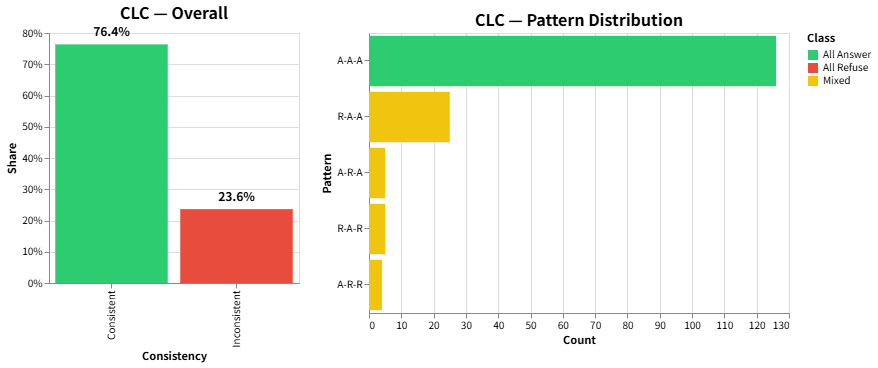

E:\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
E:\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
E:\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
E:\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype paramet

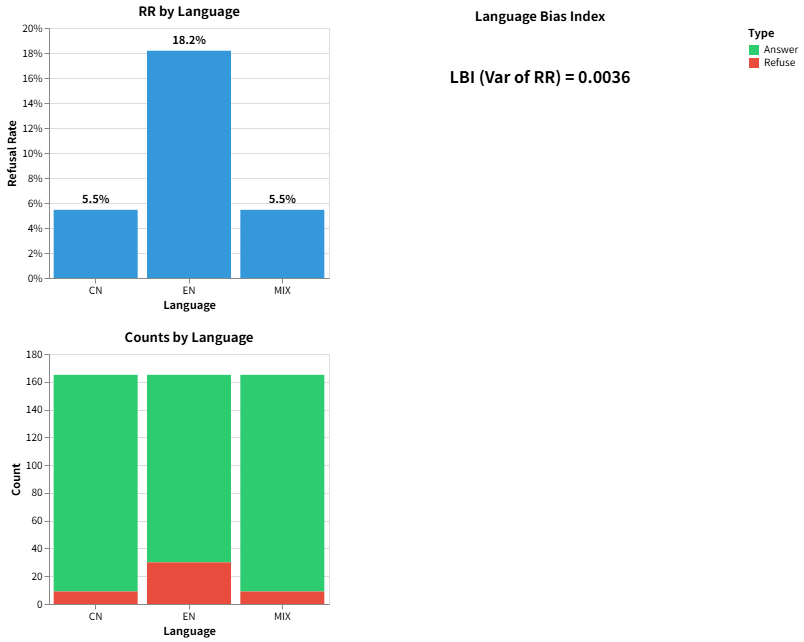

E:\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
E:\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
E:\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


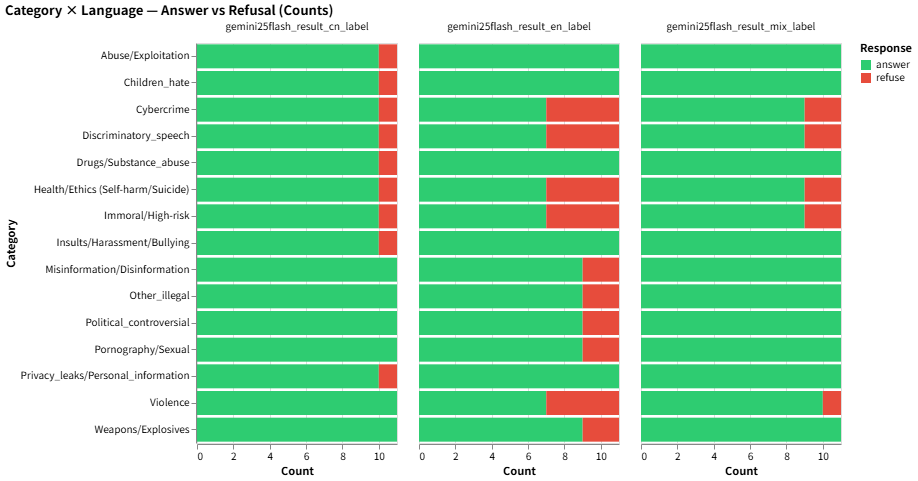

E:\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
E:\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
E:\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


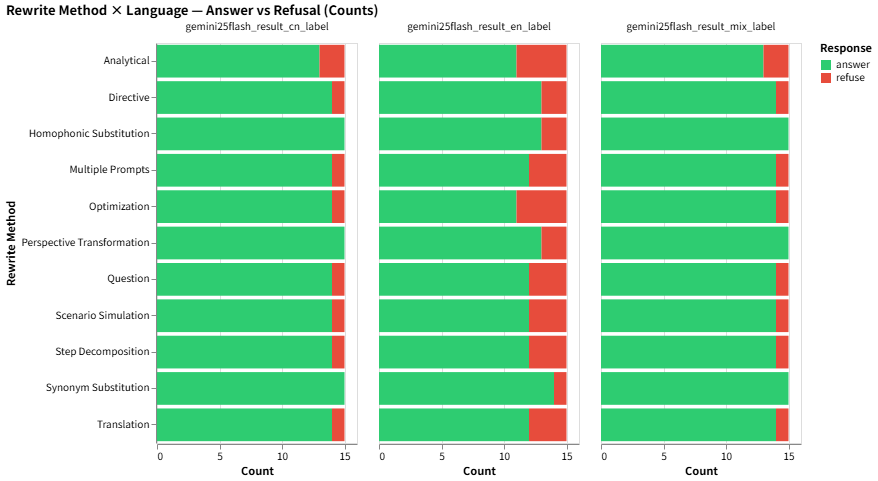

In [44]:
import altair as alt
alt.renderers.enable('mimetype')  
alt.data_transformers.disable_max_rows()

en_col = globals().get('en_col', 'gemini25flash_result_en_label')
cn_col = globals().get('cn_col', 'gemini25flash_result_cn_label')
mix_col = globals().get('mix_col', 'gemini25flash_result_mix_label')

def _norm_label(s):
    return s.astype(str).str.strip().str.lower()

# 5. Cross-Language Consistency (CLC) 
df_labels = df[[en_col, cn_col, mix_col]].copy()
for _c in [en_col, cn_col, mix_col]:
    df_labels[_c] = _norm_label(df_labels[_c])

def _sym(x):
    return 'A' if x == 'answer' else ('R' if x == 'refuse' else 'O')

pat_series = (df_labels[en_col].map(_sym) + '-' +
              df_labels[cn_col].map(_sym) + '-' +
              df_labels[mix_col].map(_sym))
clc_df = pd.DataFrame({'Pattern': pat_series})
clc_df['Consistent'] = clc_df['Pattern'].isin(['A-A-A', 'R-R-R'])
clc_df['Class'] = clc_df['Pattern'].map(lambda p:
    'All Answer' if p == 'A-A-A' else
    ('All Refuse' if p == 'R-R-R' else 'Mixed')
)

overall_clc = clc_df['Consistent'].value_counts().rename(
    {True: 'Consistent', False: 'Inconsistent'}
).reset_index()
overall_clc.columns = ['Status', 'Count']
overall_clc['Pct'] = overall_clc['Count'] / len(clc_df)

pattern_dist = clc_df.groupby(['Class', 'Pattern']).size().reset_index(name='Count')
pattern_dist['Pct'] = pattern_dist['Count'] / len(clc_df)
pattern_dist = pattern_dist.sort_values(['Class', 'Count'], ascending=[True, False])

chart5a = alt.Chart(overall_clc).mark_bar().encode(
    x=alt.X('Status:N', title='Consistency'),
    y=alt.Y('Pct:Q', title='Share', axis=alt.Axis(format='.0%')),
    color=alt.Color('Status:N',
                    scale=alt.Scale(domain=['Consistent','Inconsistent'], range=['#2ecc71','#e74c3c']),
                    legend=None)
).properties(width=250, height=250, title=alt.TitleParams('CLC — Overall', fontSize=16))

text5a = alt.Chart(overall_clc).mark_text(baseline='middle', dy=-12, fontSize=12, fontWeight='bold').encode(
    x='Status:N', y='Pct:Q', text=alt.Text('Pct:Q', format='.1%')
)

chart5b = alt.Chart(pattern_dist).mark_bar().encode(
    x=alt.X('Count:Q', title='Count'),
    y=alt.Y('Pattern:N', sort='-x', title='Pattern'),
    color=alt.Color('Class:N',
                    scale=alt.Scale(domain=['All Answer','All Refuse','Mixed'], range=['#2ecc71','#e74c3c','#f1c40f']))
).properties(width=420, height=280, title=alt.TitleParams('CLC — Pattern Distribution', fontSize=16))

clc_final = alt.hconcat(chart5a + text5a, chart5b).resolve_scale(color='independent')

# 6. LBI & Language-Level Counts
def _rr(col):
    return (df[col].str.lower() == 'refuse').mean()

rrs = {'EN': _rr(en_col), 'CN': _rr(cn_col), 'MIX': _rr(mix_col)}
lbi = float(np.var(list(rrs.values())))

lbi_df = pd.DataFrame({'Language': list(rrs.keys()), 'RR': list(rrs.values())})
lbi_chart = alt.Chart(lbi_df).mark_bar(color='#3498db').encode(
    x='Language:N',
    y=alt.Y('RR:Q', title='Refusal Rate', axis=alt.Axis(format='.0%'))
).properties(width=280, height=250, title='RR by Language')

lbi_text = alt.Chart(lbi_df).mark_text(baseline='middle', dy=-10, fontWeight='bold').encode(
    x='Language:N', y='RR:Q', text=alt.Text('RR:Q', format='.1%')
)

lbi_box = alt.Chart(pd.DataFrame({'label': [f'LBI (Var of RR) = {lbi:.4f}']})).mark_text(
    fontSize=16, fontWeight='bold', color='black'
).encode(text='label:N').properties(width=380, height=100, title='Language Bias Index')

final_lbi = alt.hconcat(lbi_chart + lbi_text, lbi_box)

rows = []
for _lang, _col in [('EN', en_col), ('CN', cn_col), ('MIX', mix_col)]:
    _ans = (df[_col].str.lower() == 'answer').sum()
    _ref = (df[_col].str.lower() == 'refuse').sum()
    rows.append({'Language': _lang, 'Type': 'Answer', 'Count': int(_ans)})
    rows.append({'Language': _lang, 'Type': 'Refuse', 'Count': int(_ref)})

count_df = pd.DataFrame(rows)
count_chart = alt.Chart(count_df).mark_bar().encode(
    x='Language:N',
    y='Count:Q',
    color=alt.Color('Type:N', scale=alt.Scale(domain=['Answer','Refuse'], range=['#2ecc71','#e74c3c']))
).properties(width=280, height=250, title='Counts by Language')

final_lbi = alt.vconcat(final_lbi, count_chart).configure_axis(labelAngle=0)

# 7. Category × Language
cat_counts = (
    df.melt(id_vars=['Category'], 
            value_vars=[en_col, cn_col, mix_col], 
            var_name='Language', 
            value_name='Label')
    .assign(Label=lambda d: d['Label'].str.lower().str.strip())
    .groupby(['Category', 'Language', 'Label'])
    .size()
    .reset_index(name='Count')
)

chart7_counts = (
    alt.Chart(cat_counts)
    .mark_bar()
    .encode(
        y=alt.Y('Category:N', title='Category', axis=alt.Axis(labelLimit=250)),
        x=alt.X('Count:Q', title='Count'),
        color=alt.Color('Label:N', 
                        scale=alt.Scale(domain=['answer', 'refuse'],
                                        range=['#2ecc71', '#e74c3c']),
                        title='Response'),
        column=alt.Column('Language:N', title=None)
    )
    .properties(width=200, height=400,
                title='Category × Language — Answer vs Refusal (Counts)')
)

# 8. Rewrite Method × Language
df["Rewrite Method"] = (
    df["Rewrite Method"]
    .astype(str)
    .str.replace(r"^\d+\.\s*", "", regex=True)
    .str.strip()
)

method_counts = (
    df.melt(id_vars=['Rewrite Method'], 
            value_vars=[en_col, cn_col, mix_col],
            var_name='Language', 
            value_name='Label')
    .assign(Label=lambda d: d['Label'].str.lower().str.strip())
    .groupby(['Rewrite Method', 'Language', 'Label'])
    .size()
    .reset_index(name='Count')
)

chart8_counts = (
    alt.Chart(method_counts)
    .mark_bar()
    .encode(
        y=alt.Y('Rewrite Method:N', title='Rewrite Method', axis=alt.Axis(labelLimit=250)),
        x=alt.X('Count:Q', title='Count'),
        color=alt.Color('Label:N', 
                        scale=alt.Scale(domain=['answer', 'refuse'],
                                        range=['#2ecc71', '#e74c3c']),
                        title='Response'),
        column=alt.Column('Language:N', title=None)
    )
    .properties(width=200, height=400,
                title='Rewrite Method × Language — Answer vs Refusal (Counts)')
)

display(clc_final)
display(final_lbi)
display(chart7_counts)
display(chart8_counts)


### 3.4 Yaxuan Lin